<a href="https://colab.research.google.com/github/rufous86/hh_api/blob/main/hh_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ! pip install geopy

In [4]:
import requests
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import plotly.express as px

In [5]:
res = []
def get_vacancy(vacancies, pages=50):
    for vacancy in vacancies:
        print(f'collecting {vacancy}')
        for page in tqdm(range(pages)):
            params = {
                'text': f'NAME:{vacancy}',
                'page': page,
                'per_page': 100
                }
            req = requests.get('https://api.hh.ru/vacancies', params).json()
            if 'items' in req.keys():
                res.extend(req['items'])

vacancies = ['аналитик', 'данные', 'data', 'analyst']
get_vacancy(vacancies)

data = pd.DataFrame(res)
data.shape

collecting аналитик


  0%|          | 0/50 [00:00<?, ?it/s]

collecting данные


  0%|          | 0/50 [00:00<?, ?it/s]

collecting data


  0%|          | 0/50 [00:00<?, ?it/s]

collecting analyst


  0%|          | 0/50 [00:00<?, ?it/s]

(5076, 30)

In [55]:
df = data.copy()
columns = ['name', 'salary', 'schedule', 'area']
df = df[columns]
df.head()

,name,salary,schedule,area
0,Аналитик,"{'from': 60000, 'to': None, 'currency': 'RUR',...","{'id': 'fullDay', 'name': 'Полный день'}","{'id': '1641', 'name': 'Набережные Челны', 'ur..."
1,Cпециалист по работе с данными и аналитике,"{'from': 115000, 'to': 115000, 'currency': 'RU...","{'id': 'fullDay', 'name': 'Полный день'}","{'id': '1', 'name': 'Москва', 'url': 'https://..."
2,"Системный аналитик (удалённая работа, middle/s...","{'from': 300000, 'to': 400000, 'currency': 'RU...","{'id': 'remote', 'name': 'Удаленная работа'}","{'id': '1', 'name': 'Москва', 'url': 'https://..."
3,Ведущий аналитик,"{'from': 120000, 'to': 180000, 'currency': 'RU...","{'id': 'fullDay', 'name': 'Полный день'}","{'id': '2090', 'name': 'Королев', 'url': 'http..."
4,Аналитик,None,"{'id': 'fullDay', 'name': 'Полный день'}","{'id': '1', 'name': 'Москва', 'url': 'https://..."


In [56]:
df["city"] = (df["area"]
                     .apply(lambda x: x.get("name") 
                                      if isinstance(x, dict) 
                                      else np.nan))
df["schedule"] = (df["schedule"]
                     .apply(lambda x: x.get("id") 
                                      if isinstance(x, dict) 
                                      else np.nan))
df["salary_from"] = (df["salary"]
                     .apply(lambda x: x.get("from") 
                                      if isinstance(x, dict) 
                                      else np.nan))
df["salary_to"] = (df["salary"]
                     .apply(lambda x: x.get("to") 
                                      if isinstance(x, dict) 
                                      else np.nan))
df["salary_currency"] = (df["salary"]
                     .apply(lambda x: x.get("currency") 
                                      if isinstance(x, dict) 
                                      else np.nan))
# df["lat"] = (df["address"]
#                      .apply(lambda x: x.get("lat") 
#                                       if isinstance(x, dict) 
#                                       else np.nan))
# df["lon"] = (df["address"]
#                      .apply(lambda x: x.get("lng") 
#                                       if isinstance(x, dict) 
#                                       else np.nan))

df = df.drop(['salary', 'area'], axis=1)

In [57]:
df = df[df['salary_currency'] == 'RUR']
df.head()

,name,schedule,city,salary_from,salary_to,salary_currency
0,Аналитик,fullDay,Набережные Челны,60000.0,NaN,RUR
1,Cпециалист по работе с данными и аналитике,fullDay,Москва,115000.0,115000.0,RUR
2,"Системный аналитик (удалённая работа, middle/s...",remote,Москва,300000.0,400000.0,RUR
3,Ведущий аналитик,fullDay,Королев,120000.0,180000.0,RUR
9,Аналитик,fullDay,Таганрог,92000.0,NaN,RUR


In [58]:
df['salary_currency'].value_counts()

RUR    1241
Name: salary_currency, dtype: int64

In [59]:
df['salary_from'] = df['salary_from'].fillna(df['salary_to'])
df['salary_to'] = df['salary_to'].fillna(df['salary_from'])

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1241 entries, 0 to 5075
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1241 non-null   object 
 1   schedule         1241 non-null   object 
 2   city             1241 non-null   object 
 3   salary_from      1241 non-null   float64
 4   salary_to        1241 non-null   float64
 5   salary_currency  1241 non-null   object 
dtypes: float64(2), object(4)
memory usage: 67.9+ KB


In [58]:
# df = df[df['salary_currency'] == 'RUR'][['name', 'schedule', 'city', 'salary_from', 'salary_to', 'salary_currency', 'lat', 'lon']]

In [59]:
# df = df.dropna(axis=0, subset=['lat', 'lon'])
# df.info()

In [61]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geo")

def get_coords(city):
    geo = geolocator.geocode(city)
    if geo:
        return geo.longitude, geo.latitude
    else:
        return np.nan, np.nan


coords = pd.DataFrame(data=df['city'].unique(), columns=['city'])
coords['(lon, lat)'] = (coords['city']
                        .apply(lambda x: get_coords(x)))


coords['lon'] = (coords['(lon, lat)']
                        .apply(lambda x: x[0]))
coords['lat'] = (coords['(lon, lat)']
                        .apply(lambda x: x[1]))
coords = coords.drop('(lon, lat)', axis=1)

In [62]:
total_vac = dict(df
            .groupby('city')['name']
            .agg('count')
            )

In [63]:
df = df.merge(coords, on='city')
df['salary_mean'] = (df['salary_from'] + df['salary_to']) / 2
df['total_vac'] = (df['city']
                .apply(lambda x: total_vac[x]))
df.head()

,name,schedule,city,salary_from,salary_to,salary_currency,lon,lat,salary_mean,total_vac
0,Аналитик,fullDay,Набережные Челны,60000.0,60000.0,RUR,52.399207,55.741977,60000.0,6
1,Аналитик,fullDay,Набережные Челны,35000.0,40000.0,RUR,52.399207,55.741977,37500.0,6
2,Аналитик,fullDay,Набережные Челны,15000.0,60000.0,RUR,52.399207,55.741977,37500.0,6
3,Специалист по Data Science,fullDay,Набережные Челны,76967.0,76967.0,RUR,52.399207,55.741977,76967.0,6
4,Аналитик,fullDay,Набережные Челны,60000.0,60000.0,RUR,52.399207,55.741977,60000.0,6


In [81]:
df_grouped = (df
     .groupby('city')[['salary_mean', 'lon', 'lat', 'total_vac']]
     .agg('mean')
                         )

In [85]:
df_grouped['city'] = df_grouped.index

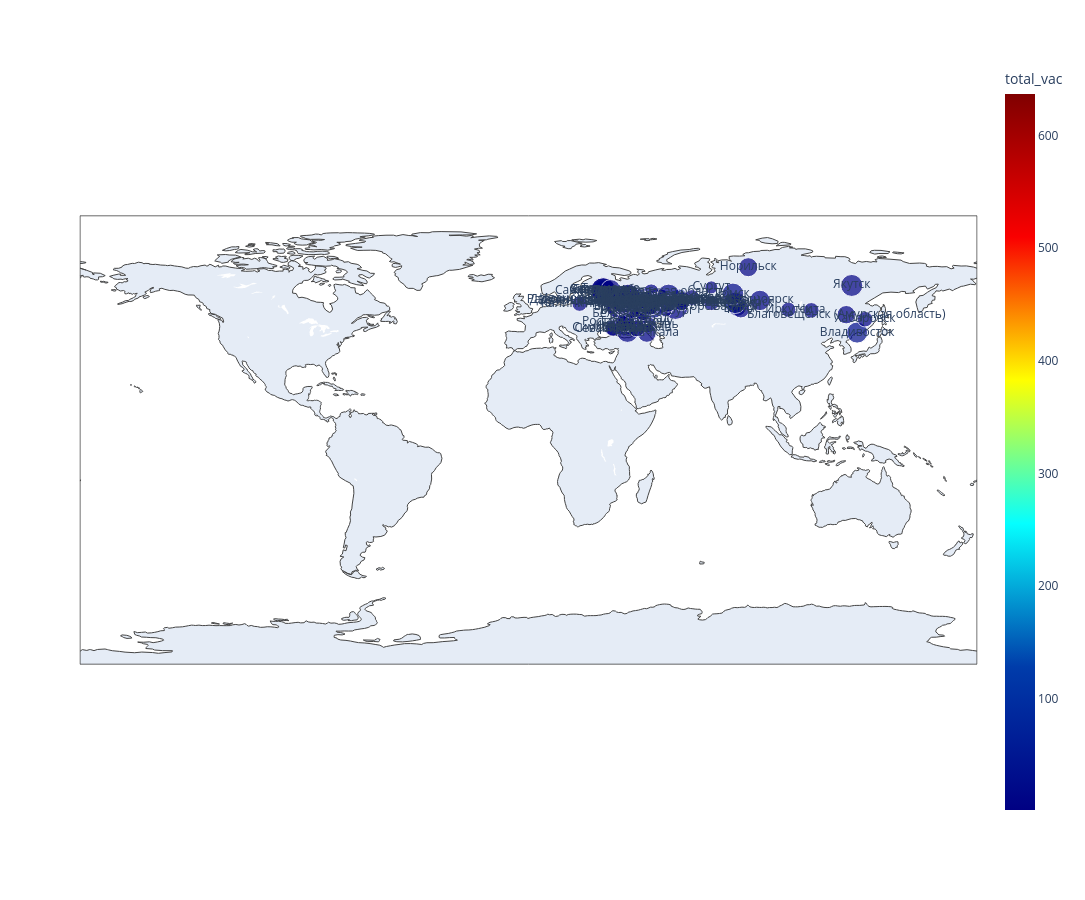

In [116]:
fig = px.scatter_geo(df_grouped, lat='lat', lon='lon', 
                     color='total_vac', text='city', 
                     color_continuous_scale=px.colors.sequential.Jet, 
                     size='salary_mean', width=1000, height=900)
fig.show()